#### Обзор данных
- **'region'** регион;
- **'region_code'** код региона;
- **'year'** год статистики;
- **'population'** население, тыс. человек;
- **'unemployed_pop'** число безработных в возрасте 15-72 лет, тыс. чел.;
- **'poor_pop'** численость населения с денежным доходом ниже границы бедности, тыс. чел.;
- **'disabled_people'** количество инвалидов;
- **'avg_salary'** среднемесячная заработная плата, тыс. руб.;
- **'median_salary'** медианная заработная плата, руб.;
- **'new_houses'** введенная площадь жилых домов на 1000 населения, кв.м.;
- **'divorces'** количество разводов;
- **'orphans'** число детей, родители которых лишены родительских прав;
- **'alcohol_sold'** продажа алкогольных напитков, декалитры;
- **'abortions'** количество абортов;
- **'crimes'** количество всех зарегестрированных преступлений.

Данные были собраны с сайтов [Росстат](https://rosstat.gov.ru/), [ЕМИСС](https://www.fedstat.ru/) и [портала парвовой статистики](http://crimestat.ru/) в промежутке между 2012-2022 годами. 
Поскольку Севастополь и Республика Крым вошли в состав РФ после 2014 года, данные по ним до этого года в датасет не вошли.

### EDA

In [1]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import catboost
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('data.ods')
data['year'] = data['year'].astype("object")
data['region_code'] = data['region_code'].astype("object")

Обобщенный отчет по всем данным можно найти в документе summerize.html

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931 entries, 0 to 930
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           931 non-null    object 
 1   region_code      931 non-null    object 
 2   year             931 non-null    object 
 3   population       929 non-null    float64
 4   unemployed_pop   929 non-null    float64
 5   poor_pop         846 non-null    float64
 6   disabled_people  926 non-null    float64
 7   avr_salary       927 non-null    float64
 8   median_salary    591 non-null    float64
 9   new_houses       931 non-null    float64
 10  divorces         843 non-null    float64
 11  orphans          506 non-null    float64
 12  alcohol_sold     930 non-null    float64
 13  abortions        846 non-null    float64
 14  crimes           931 non-null    int64  
dtypes: float64(11), int64(1), object(3)
memory usage: 109.2+ KB


In [4]:
data.population = data.population*1000
data.unemployed_pop = data.unemployed_pop*1000
data.poor_pop = data.poor_pop*1000
data.avr_salary = data.avr_salary*1000

In [5]:
# Пропущенные значения:
missing_values = [feature for feature in data.columns if data[feature].isnull().sum() > 0]

for feature in missing_values:
    print(f"{feature}: {100 * np.round(data[feature].isnull().mean(), 2)}% пропущенных значений")

population: 0.0% пропущенных значений
unemployed_pop: 0.0% пропущенных значений
poor_pop: 9.0% пропущенных значений
disabled_people: 1.0% пропущенных значений
avr_salary: 0.0% пропущенных значений
median_salary: 37.0% пропущенных значений
divorces: 9.0% пропущенных значений
orphans: 46.0% пропущенных значений
alcohol_sold: 0.0% пропущенных значений
abortions: 9.0% пропущенных значений


Среди всех признаков количество детей-сирот и медианная зп имею слишком большие значения пропуска. На мой взгляд признаки важные, поэтому заполним их с условием того, что возможно их придется удалить.

<Axes: xlabel='year', ylabel='crimes'>

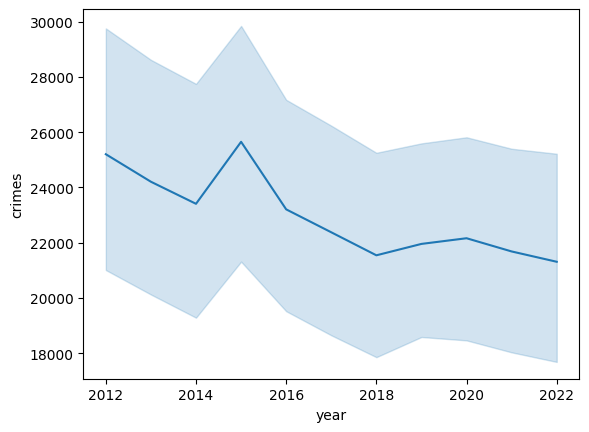

In [6]:
sns.lineplot(data, x = 'year', y = 'crimes')

Видим что суммарно по регионам преступность в РФ имеет нисходящий тренд, за исключением 2015 года.

In [7]:
data

,region,region_code,year,population,unemployed_pop,poor_pop,disabled_people,avr_salary,median_salary,new_houses,divorces,orphans,alcohol_sold,abortions,crimes
0,Алтайский край,22.0,2012,2407200.0,74385.0,NaN,218000.0,110500.000000,NaN,269.000000,12288.0,1123.0,4200.000,16024.0,42102
1,Алтайский край,22.0,2013,2398700.0,95790.0,422200.0,211000.0,104900.000000,12545.4,278.000000,13259.0,1059.0,3545.600,16183.0,45024
2,Алтайский край,22.0,2014,2390600.0,83390.0,409600.0,207000.0,99928.653941,14456.2,316.000000,13243.0,932.0,2567.600,14821.0,44096
3,Алтайский край,22.0,2015,2384800.0,94779.0,429500.0,203000.0,89953.500872,16554.6,374.000000,10662.0,1024.0,2596.500,13444.0,48582
4,Алтайский край,22.0,2016,2376700.0,99645.0,423000.0,198000.0,98400.000000,16923.2,318.000000,10369.0,975.0,2369.600,13624.0,44576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,Ярославская область,76.0,2018,1265684.0,36428.0,128900.0,112000.0,106000.000000,21865.9,608.000000,5080.0,NaN,2649.336,5284.0,16710
927,Ярославская область,76.0,2019,1259600.0,35037.0,129900.0,108000.0,101590.613784,23183.9,619.000000,5400.0,NaN,2615.999,4608.0,17709
928,Ярославская область,76.0,2020,1253400.0,47400.0,124000.0,104000.0,100893.629288,NaN,598.000000,4669.0,NaN,2605.988,3919.0,16088
929,Ярославская область,76.0,2021,1241400.0,38999.0,110400.0,95358.0,102000.000000,NaN,615.766488,5584.0,NaN,2528.644,3685.0,16066


In [8]:
# Заполняем пропуск через группировку по регионам, используя интерполяцию в обе стороны
data = data.groupby('region').apply(lambda x : x.interpolate(limit_direction = "both"))
data.reset_index(drop=True, inplace=True)

In [9]:
columns_to_exclude = ['avr_salary', 'median_salary','region', 'region_code','year']
# Получение списка всех колонок, кроме указанных в columns_to_exclude
columns_for_norm = [col for col in data.columns if col not in columns_to_exclude]
# Переводим все оставшиеся признаки в относительную величину на душу населения:
data[columns_for_norm] = data[columns_for_norm].div(data['population'], axis=0)
data.drop(['population'], axis=1, inplace =True)
data

,region,region_code,year,unemployed_pop,poor_pop,disabled_people,avr_salary,median_salary,new_houses,divorces,orphans,alcohol_sold,abortions,crimes
0,Алтайский край,22.0,2012,0.030901,0.175390,0.090562,110500.000000,12545.4,0.000112,0.005105,0.000467,0.001745,0.006657,0.017490
1,Алтайский край,22.0,2013,0.039934,0.176012,0.087964,104900.000000,12545.4,0.000116,0.005528,0.000441,0.001478,0.006747,0.018770
2,Алтайский край,22.0,2014,0.034882,0.171338,0.086589,99928.653941,14456.2,0.000132,0.005540,0.000390,0.001074,0.006200,0.018446
3,Алтайский край,22.0,2015,0.039743,0.180099,0.085122,89953.500872,16554.6,0.000157,0.004471,0.000429,0.001089,0.005637,0.020372
4,Алтайский край,22.0,2016,0.041926,0.177978,0.083309,98400.000000,16923.2,0.000134,0.004363,0.000410,0.000997,0.005732,0.018755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,г.Санкт-Петербург,78.0,2018,0.008347,0.065490,0.116220,109100.000000,33994.8,0.000138,0.004845,0.000088,0.001932,0.003488,0.009608
927,г.Санкт-Петербург,78.0,2019,0.007760,0.064489,0.112744,104719.298792,35581.2,0.000120,0.005007,0.000087,0.001956,0.003528,0.009032
928,г.Санкт-Петербург,78.0,2020,0.016672,0.058724,0.109668,100959.209379,35581.2,0.000116,0.004216,0.000087,0.002007,0.003081,0.011358
929,г.Санкт-Петербург,78.0,2021,0.011721,0.050183,0.100749,104200.000000,35581.2,0.000120,0.004755,0.000087,0.001975,0.002921,0.011655


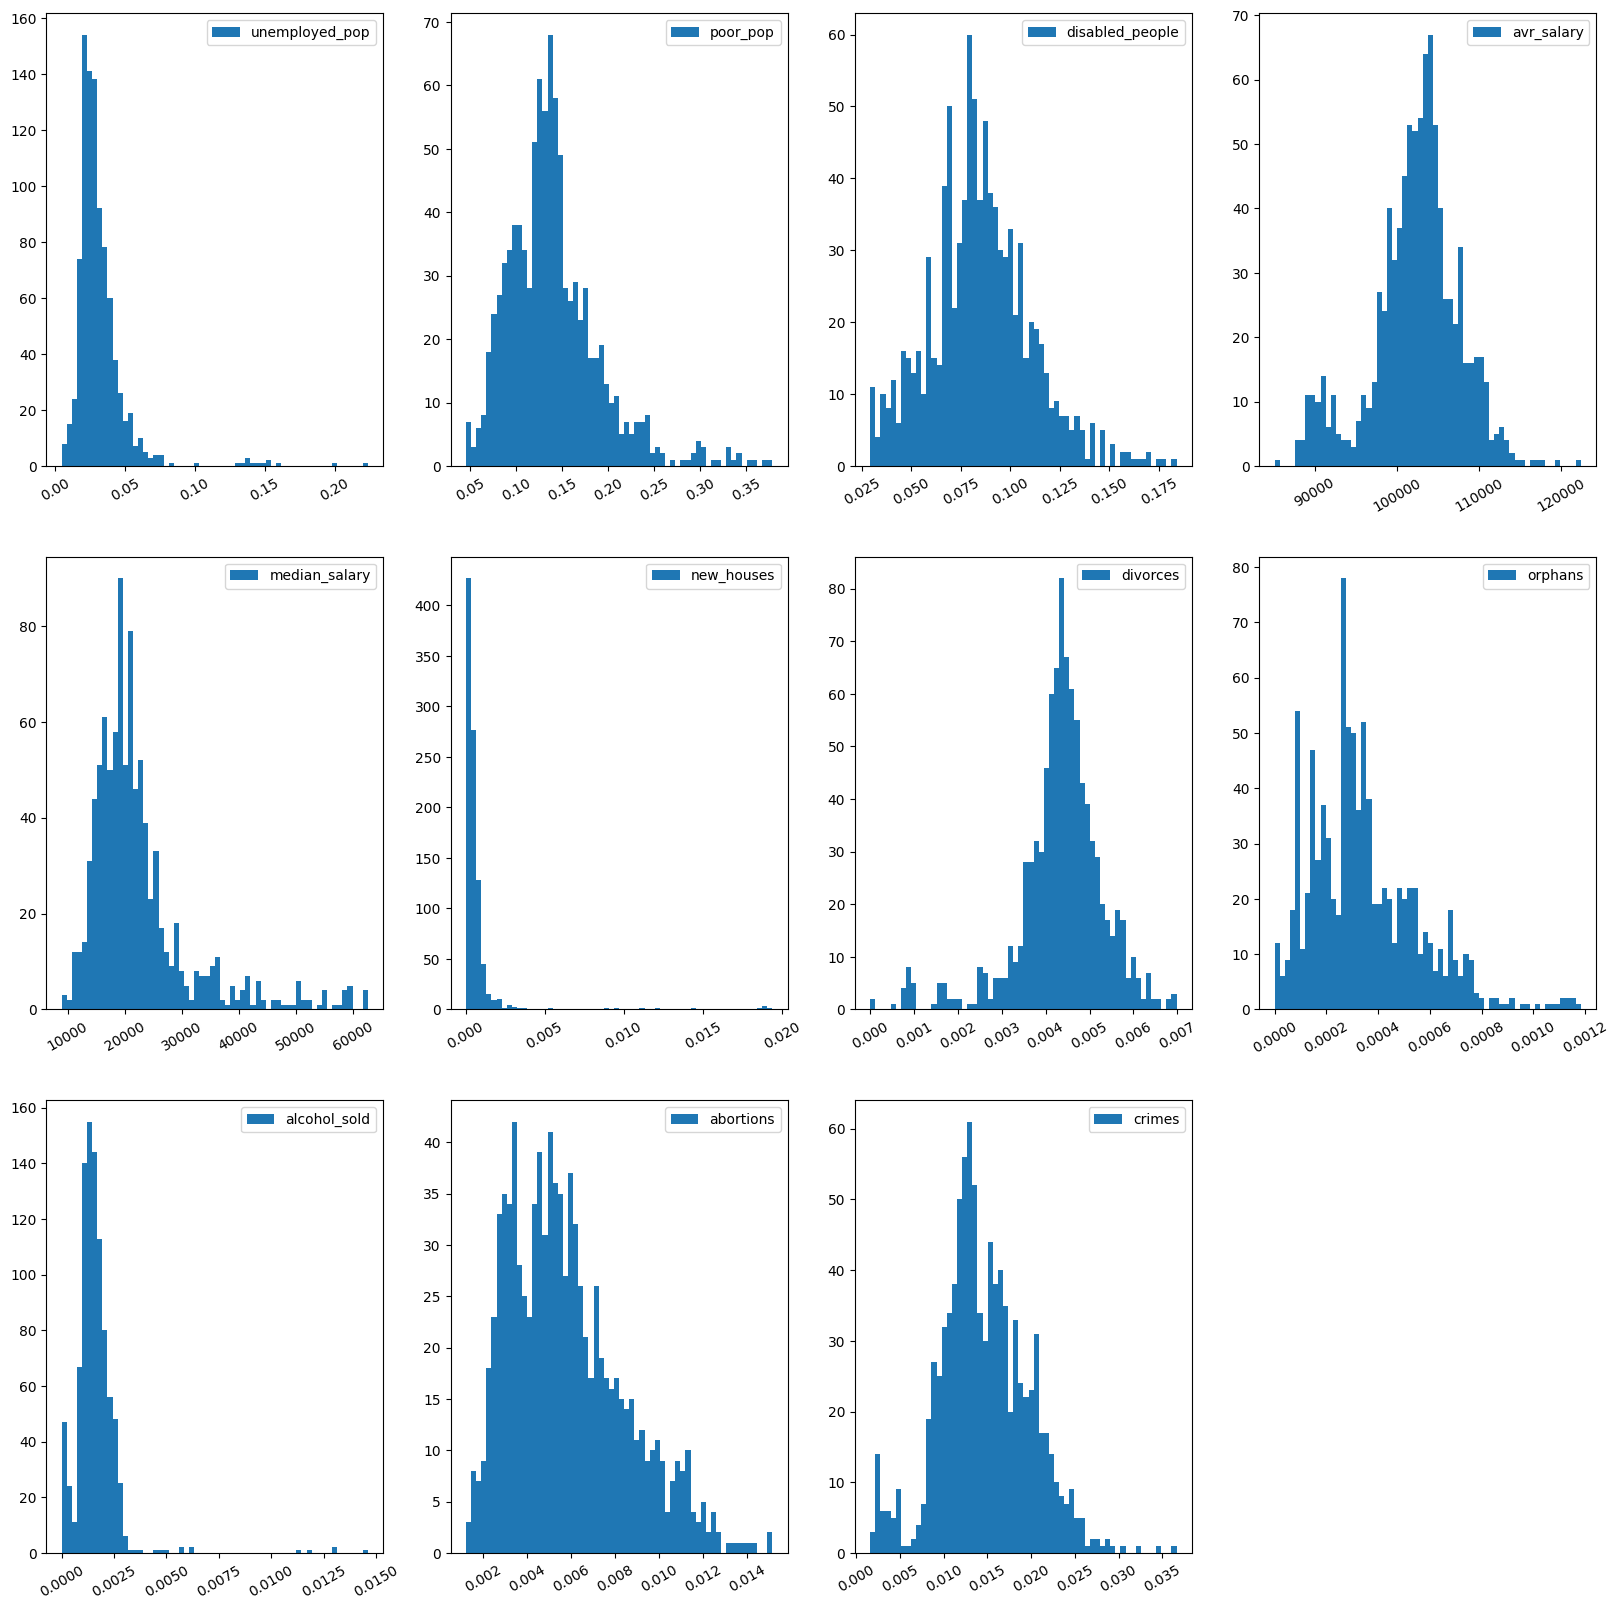

In [10]:
numeric_features = data.select_dtypes(exclude='object').columns
fig = plt.figure(figsize=(20,20))

for i in range(1,12):
    ax = fig.add_subplot(3, 4, i)
    ax.hist(data[numeric_features[i-1]],label = numeric_features[i-1], bins=60)
    plt.xticks(rotation=30)
    ax.legend()

In [11]:
# Удалим выбросы за переделами 1 и 99 персентилей. Такой диапазон выбран в связи с тем, что выборка очень маленькая
# и удаление за переделами 5-95 персентилей приведет к большей потере данных

#for feature in data.iloc[:,3:]:
#    data = data[(data[feature] >= data[feature].quantile(0.01))\
#                            & (data[feature] <= data[feature].quantile(0.99))]
#print(data.shape)

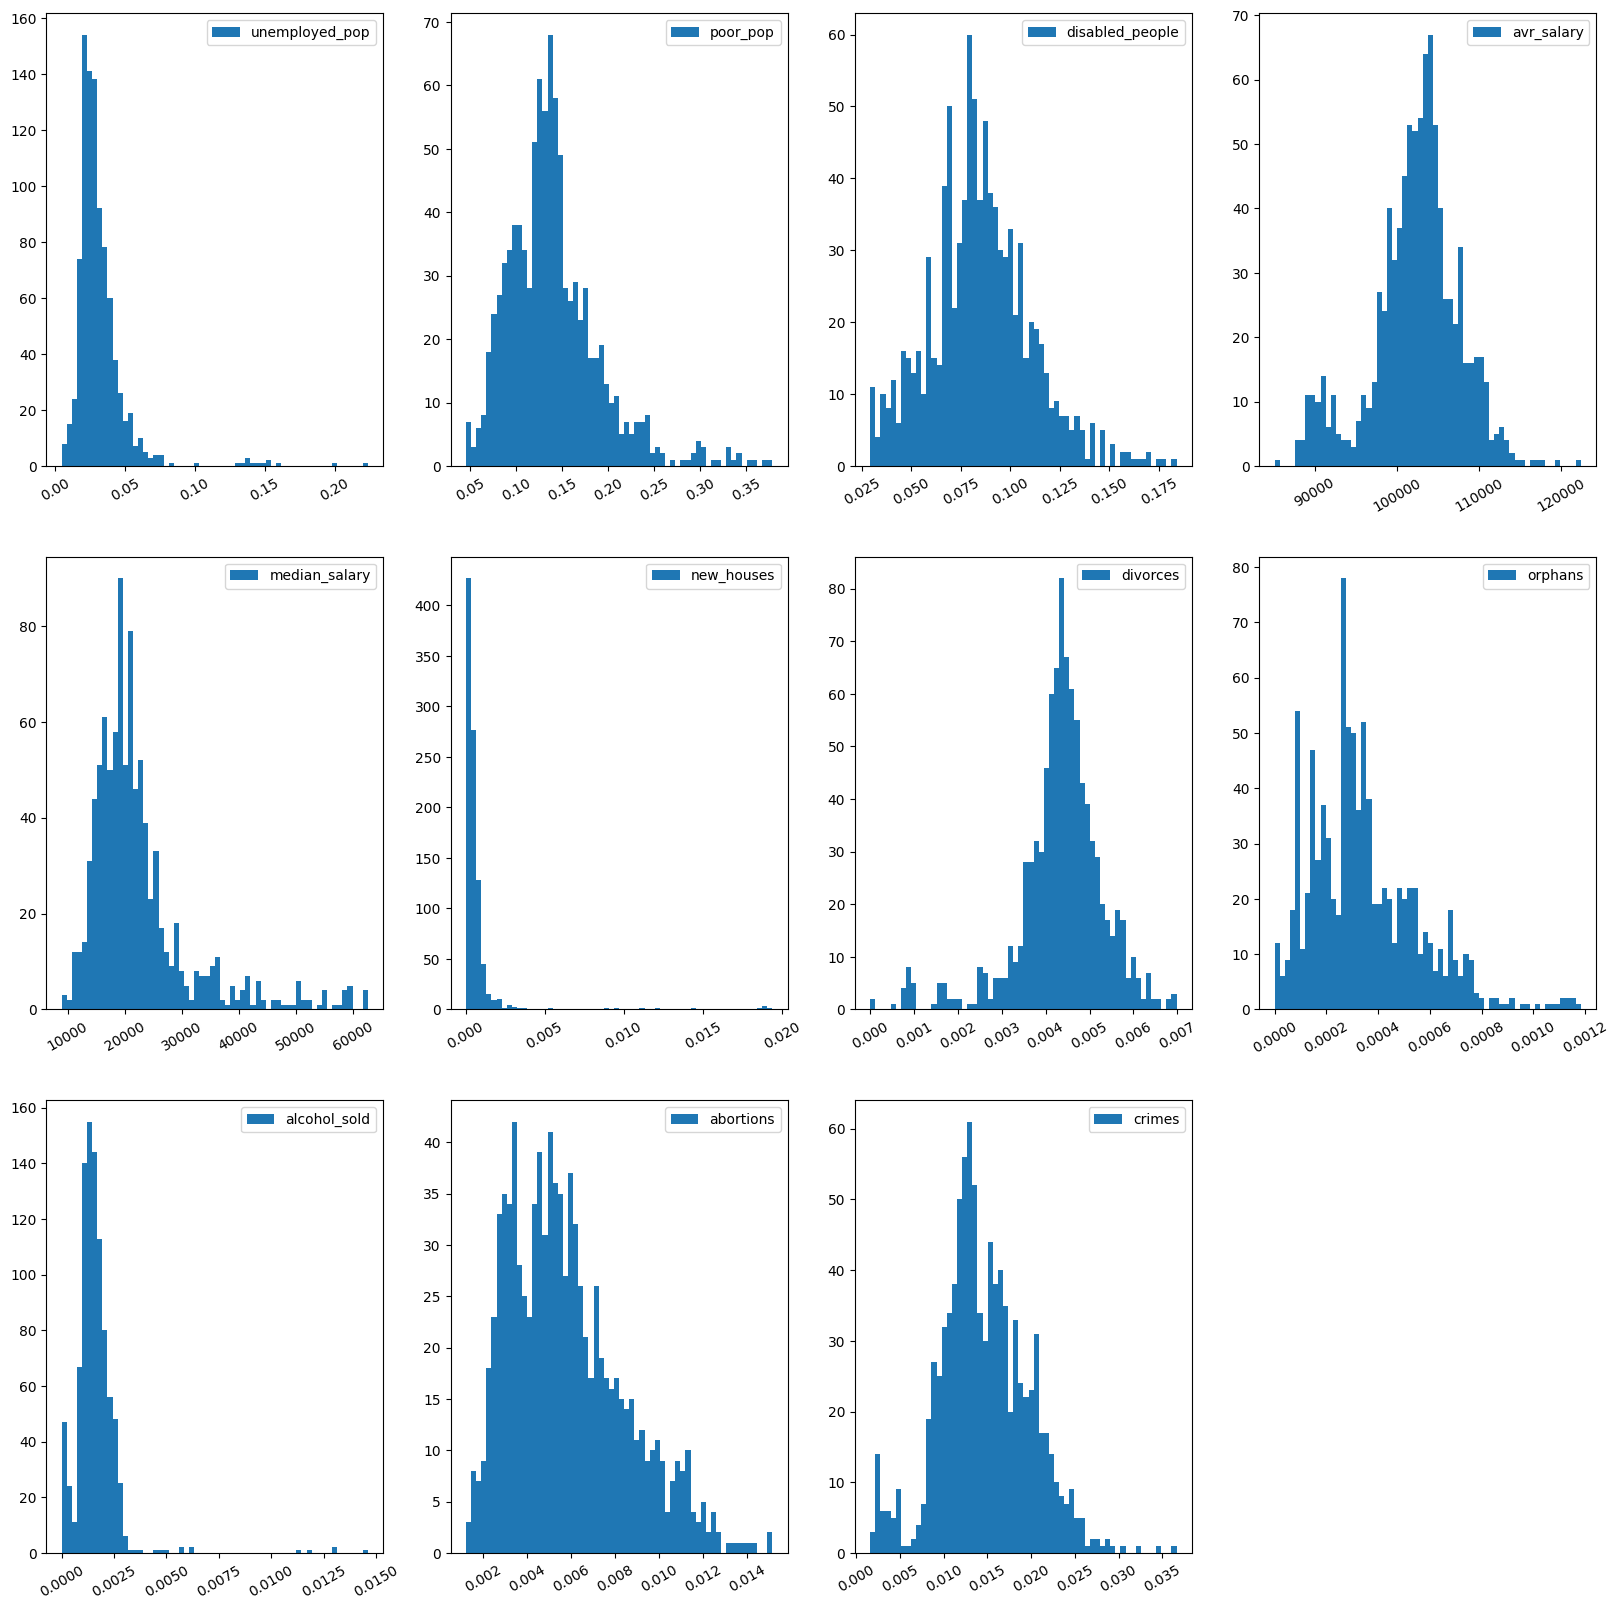

In [12]:
numeric_features = data.select_dtypes(exclude='object').columns
fig = plt.figure(figsize=(20,20))

for i in range(1,12):
    ax = fig.add_subplot(3, 4, i)
    ax.hist(data[numeric_features[i-1]],label = numeric_features[i-1], bins=60)
    plt.xticks(rotation=30)
    ax.legend()

Видим, что все данные имеют ненормальное распределение (практически во всех случаях распределение с 'хвостом'), но 'new_houses' очевидно стоит привести к логнормальному распределению

In [13]:
data['log_houses'] = np.log(data['new_houses'])

#plt.hist(data['log_houses'], bins=60)
#plt.xlabel('Logarithmic Houses')
#plt.ylabel('Frequency')
#plt.title('Histogram of Logarithmic Houses')
#plt.grid(True)
#plt.show()

<Axes: >

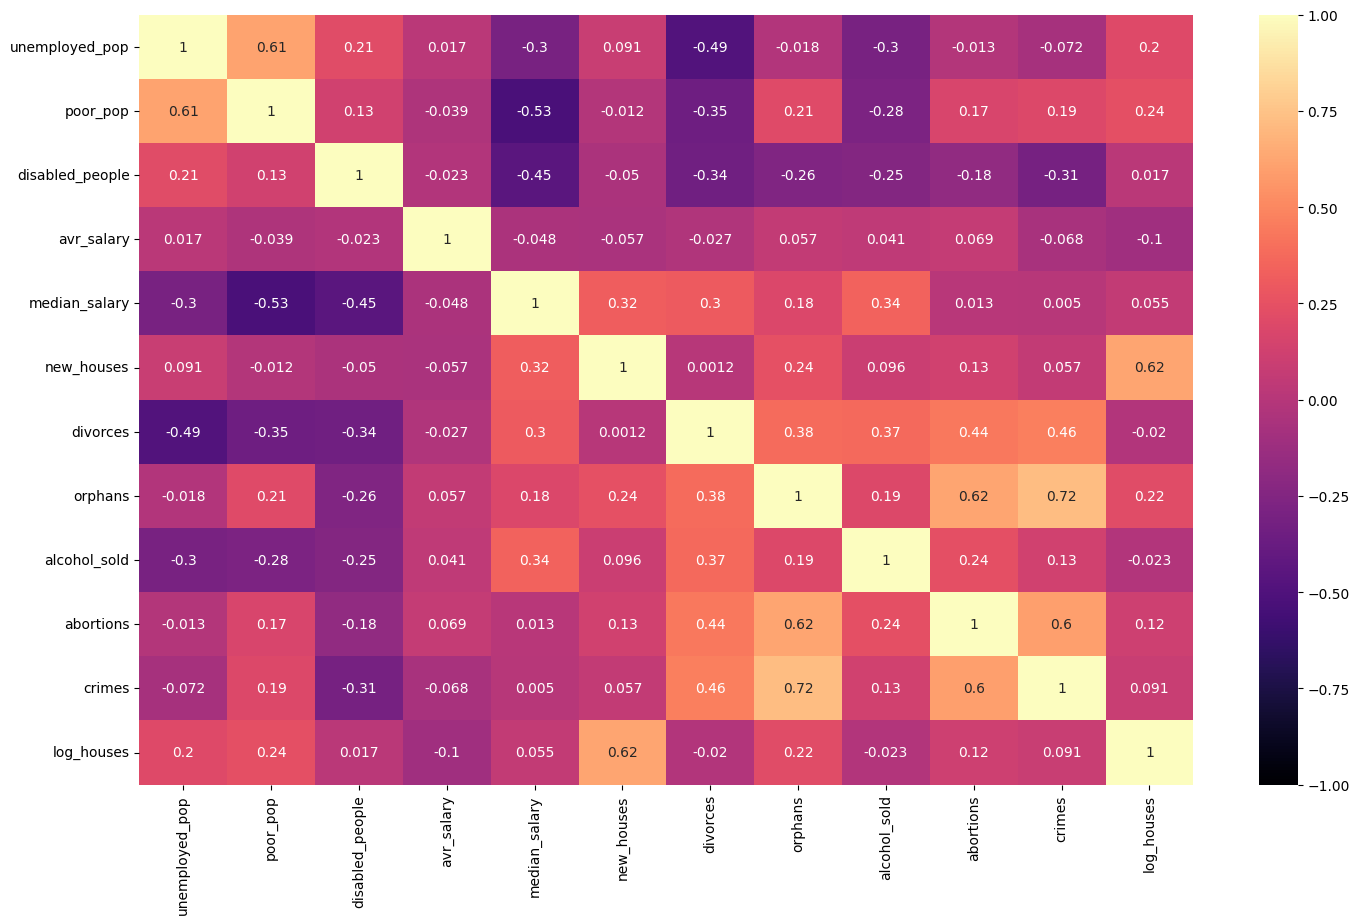

In [14]:
# Матрица корреляций:
fig, ax = plt.subplots(figsize=(17,10)) 
sns.heatmap(data.select_dtypes(exclude='object').corr(), vmin=-1, vmax=1, annot=True, cmap='magma')

В целом, после приведения к логнормальному распределению корреляция между преступлением и введенной площадью жилых домов изменилась с 0.03 до -0.08, что в целом отвечает моим ожиданиям: с увеличением введенных жилых площадей может уменьшаться преступность.

In [15]:
data.drop(['new_houses'], axis =1, inplace = True)

Из матрицы корреляции также видно, что уровень преступности сильно коррелирует с такими признаками как доли дитей-сирот, абортов и разводов на душу населения.

Также, исходя из теории Беккера следовало ожидать, что уровень преступности и уровень заработка имеют **отрицательную корреляцию**, в то время как уровень преступности с долей безработного населения - **положительную**. В целом, ожидания подтверждаются:   
crimes - avr_salary = -0.088,   
crimes - unemploeyed_pop = +0.36. 

Меня несколько удивило низкое значение корреляции crimes - avr_salary = -0.088:

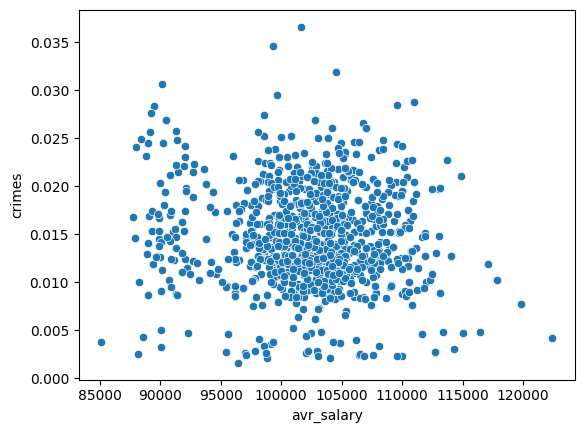

In [16]:
sns.scatterplot(data, x = 'avr_salary', y = 'crimes');

Видно, что четкой зависимости между параметрами нет, поэтому и такое низкое значение корреляции. Пока данные оставим в таком виде, но скорее всего их необходимо будет преобразовать

## Baseline
### LinearRegressor

In [17]:
data_train = data.copy()
data_train.drop(['region','region_code', 'year'], axis=1, inplace=True)

In [18]:
data_train_x = data_train.drop(['crimes'], axis=1)
data_train_y = data_train['crimes']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data_train_x, 
                                                    data_train_y,
                                                    test_size=.2, 
                                                    random_state=42)

In [20]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [21]:
lin_reg = Ridge(random_state=42)
lin_reg.fit(X_train_scale, y_train)
y_pred = lin_reg.predict(X_test_scale)
r2_lin = r2_score(y_test, y_pred)
print(f'r2 = {round(r2_lin, 3)}')

r2 = 0.608


### CatBoostRegressor

In [62]:
from catboost import CatBoostRegressor
# Создание модели CatBoostRegressor
model = CatBoostRegressor(random_seed=42,
                          verbose=200)

# Обучение модели
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=200)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Вычисление средней квадратичной ошибки
r2_boost = r2_score(y_test, y_pred)
print(f"r2:{round(r2_boost, 3)}")

Learning rate set to 0.048611
0:	learn: 0.0049042	test: 0.0051846	best: 0.0051846 (0)	total: 974us	remaining: 973ms
200:	learn: 0.0013553	test: 0.0022426	best: 0.0022426 (200)	total: 115ms	remaining: 459ms
400:	learn: 0.0008006	test: 0.0020964	best: 0.0020964 (400)	total: 230ms	remaining: 344ms
600:	learn: 0.0005142	test: 0.0020718	best: 0.0020705 (589)	total: 344ms	remaining: 228ms
800:	learn: 0.0003739	test: 0.0020636	best: 0.0020627 (795)	total: 457ms	remaining: 114ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.002062726143
bestIteration = 795

Shrink model to first 796 iterations.
r2:0.85


        Feature Id  Importances
0          orphans    31.860514
1   unemployed_pop    11.492353
2  disabled_people     9.903349
3        abortions     9.634592
4    median_salary     7.359438
5         divorces     7.118535
6       log_houses     6.877670
7         poor_pop     5.999461
8     alcohol_sold     5.885496
9       avr_salary     3.868592


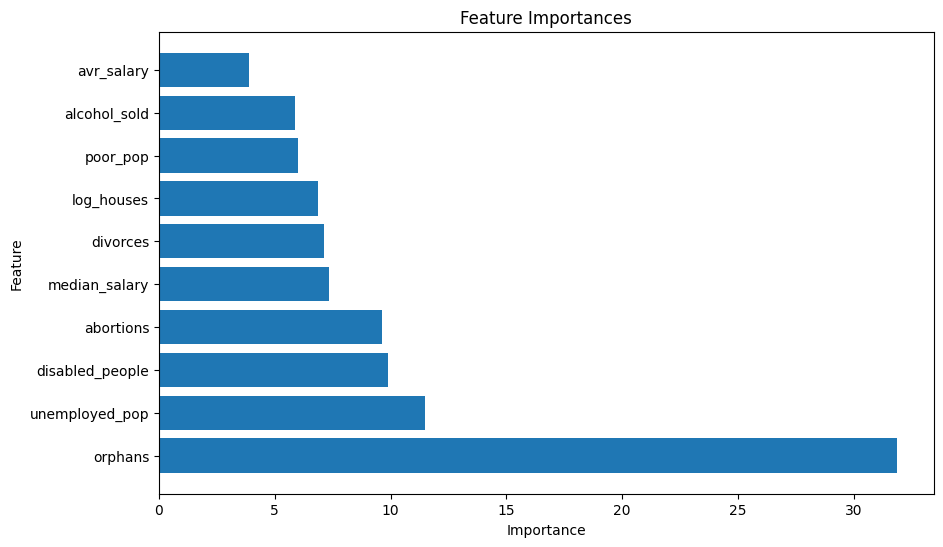

In [58]:
# Вывод важности фичей
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

# Построение графика Feature Importances
feature_names = feature_importances['Feature Id']
importance_values = feature_importances['Importances']

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()